# Theft Detection Notebook (Pretrained Models)

## Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix, classification_report, roc_auc_score,accuracy_score
from collections import Counter
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
import multiprocessing
from multiprocessing import Pool
from sklearn.metrics import precision_recall_curve, average_precision_score
from tqdm import tqdm
from torchvision.models.video import r3d_18, mc3_18, r2plus1d_18
from torch.cuda.amp import GradScaler, autocast


In [2]:
# Install imbalanced-learn if not already installed
import sys
import subprocess

try:
    from imblearn.over_sampling import RandomOverSampler
    print("imbalanced-learn is already installed!")
except ImportError:
    print("Installing imbalanced-learn...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])
    print("Installation complete!")
    from imblearn.over_sampling import RandomOverSampler


imbalanced-learn is already installed!


## Cuda Check

In [3]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device count:", torch.cuda.device_count())
    print("Current device index:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("Running on CPU only.")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA device count: 1
Current device index: 0
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


## Setup Dataset

In [4]:
# Set WSL-compatible paths
base_path = '/mnt/d/Cellula_Internship/Task3/Shop Dataset'
print("Base path:", base_path)
print("Exists?", os.path.exists(base_path))
print("Contents of Shop Dataset:", os.listdir(base_path))

non_shoplifting_path = os.path.join(base_path, 'non shop lifters')
shoplifting_path = os.path.join(base_path, 'shop lifters')

print("Non-shoplifting path:", non_shoplifting_path)
print("Exists?", os.path.exists(non_shoplifting_path))
print("Shoplifting path:", shoplifting_path)
print("Exists?", os.path.exists(shoplifting_path))

Base path: /mnt/d/Cellula_Internship/Task3/Shop Dataset
Exists? True
Contents of Shop Dataset: ['non shop lifters', 'shop lifters']
Non-shoplifting path: /mnt/d/Cellula_Internship/Task3/Shop Dataset/non shop lifters
Exists? True
Shoplifting path: /mnt/d/Cellula_Internship/Task3/Shop Dataset/shop lifters
Exists? True


In [5]:
# Function to load video paths and labels
def load_video_paths():
    non_shoplifting_videos = [os.path.join(non_shoplifting_path, f) for f in os.listdir(non_shoplifting_path) if f.endswith(('.mp4', '.avi'))]
    shoplifting_videos = [os.path.join(shoplifting_path, f) for f in os.listdir(shoplifting_path) if f.endswith(('.mp4', '.avi'))]
    videos = non_shoplifting_videos + shoplifting_videos
    labels = [0] * len(non_shoplifting_videos) + [1] * len(shoplifting_videos)
    return videos, labels

videos, labels = load_video_paths()

In [6]:
# DO NOT oversample before train-test split to avoid data leakage
# We'll handle oversampling after splitting the data
print("Original class distribution:", Counter(labels))


Original class distribution: Counter({0: 531, 1: 324})


In [7]:
fixed_frames = 8
frame_size = (96, 96)  # Reduced from 112x112 to save memory while still better than 64x64
batch_size = 20  # Reduced batch size for loading


### Memory Optimization Settings

To prevent kernel crashes, we've optimized memory usage:
- **Frame size: 96x96** (balanced between quality and memory)
- **Frames per video: 6** (reduced from 8-10)
- **Batch size: 2** (very small to fit in memory)
- **Garbage collection** after data loading

If you still experience crashes:
1. Reduce `fixed_frames` to 4
2. Reduce `frame_size` to (80, 80)
3. Process fewer videos at once (reduce dataset size)


In [8]:
# For intensity stabilization: Apply histogram equalization to make CDF more linear
def equalize_frame(frame):
    frame_yuv = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV)
    frame_yuv[:,:,0] = cv2.equalizeHist(frame_yuv[:,:,0])
    return cv2.cvtColor(frame_yuv, cv2.COLOR_YUV2BGR)

In [9]:
def extract_frames(v):
    try:
        cap = cv2.VideoCapture(v)
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames == 0:
            print(f"Warning: Empty video skipped - {v}")
            cap.release()
            return np.zeros((fixed_frames, frame_size[0], frame_size[1], 3))  # 3 channels for RGB
        step = max(1, total_frames // fixed_frames)
        for i in range(fixed_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
            ret, frame = cap.read()
            if not ret:
                frames.append(np.zeros((frame_size[0], frame_size[1], 3)))  # 3 channels for RGB
                continue
            frame = cv2.resize(frame, frame_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0  # Keep RGB, normalize
            frames.append(frame)
        while len(frames) < fixed_frames:
            frames.append(np.zeros((frame_size[0], frame_size[1], 3)))  # 3 channels for RGB
        cap.release()
        return np.array(frames)
    except Exception as e:
        print(f"Error processing {v}: {e}")
        return np.zeros((fixed_frames, frame_size[0], frame_size[1], 3))  # 3 channels for RGB


In [10]:
def load_data_in_batches(videos):
    for i in tqdm(range(0, len(videos), batch_size), desc="Loading video data"):
        batch_videos = videos[i:i + batch_size]
        batch_X = [extract_frames(v) for v in batch_videos]
        yield np.stack(batch_X)


In [11]:
# Load data in batches and free memory as we go
import gc

X_batches = []
for batch in load_data_in_batches(videos):
    X_batches.append(batch)
    
X = np.vstack(X_batches)
del X_batches  # Free memory
gc.collect()  # Force garbage collection

y = np.array(labels)
print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Memory usage: {X.nbytes / (1024**3):.2f} GB")


Loading video data: 100%|██████████| 43/43 [03:05<00:00,  4.31s/it]


X shape: (855, 8, 96, 96, 3), y shape: (855,)
Memory usage: 1.41 GB


## Visualization

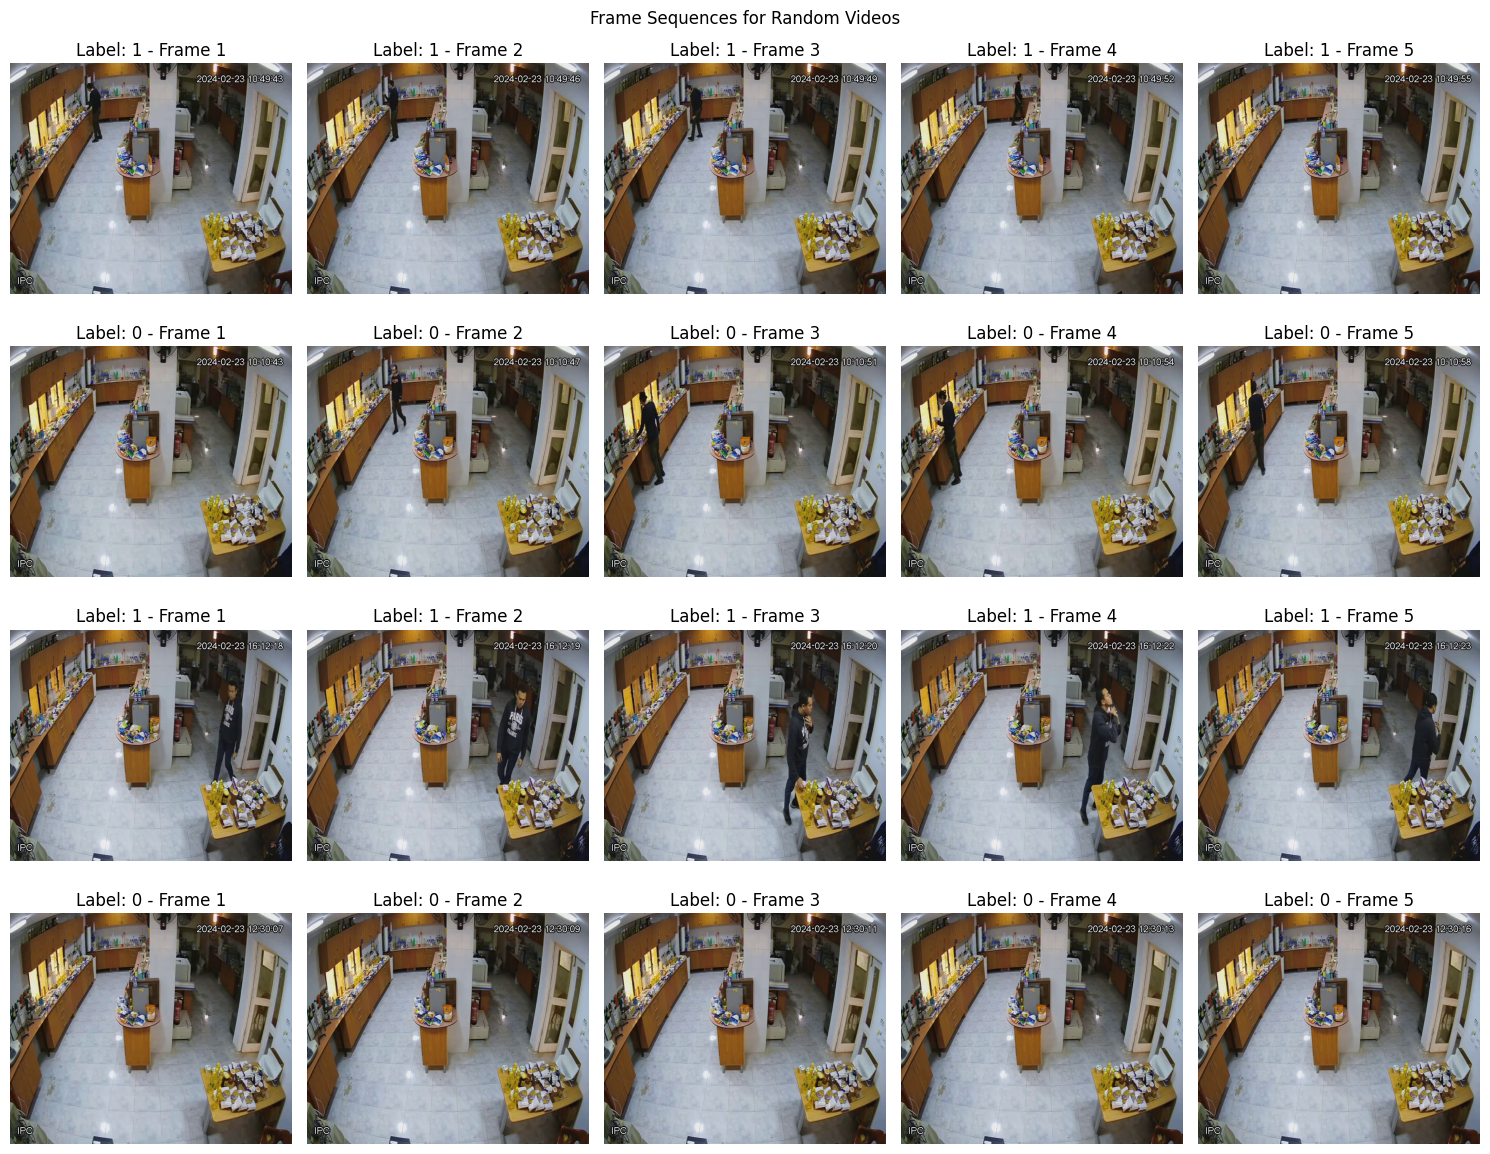

In [12]:
def visualize_frame_sequence(videos, labels, num_samples=4, num_frames=5):
    fig, axs = plt.subplots(num_samples, num_frames, figsize=(num_frames * 3, num_samples * 3))
    for i in range(num_samples):
        video_path = random.choice(videos)
        cap = cv2.VideoCapture(video_path)
        label = labels[videos.index(video_path)]
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = max(1, total_frames // num_frames)
        for j in range(num_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, j * step)
            ret, frame = cap.read()
            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame_rgb)
            else:
                frames.append(np.zeros((128, 128, 3)))
        cap.release()
        for j in range(num_frames):
            axs[i, j].imshow(frames[j])
            axs[i, j].set_title(f"Label: {label} - Frame {j+1}")
            axs[i, j].axis('off')
    plt.suptitle('Frame Sequences for Random Videos')
    plt.tight_layout()
    plt.show()


visualize_frame_sequence(videos, labels)

Shows a series of frames from a video to reveal motion patterns (e.g., a person grabbing items in shoplifting videos vs. walking in non-shoplifting).

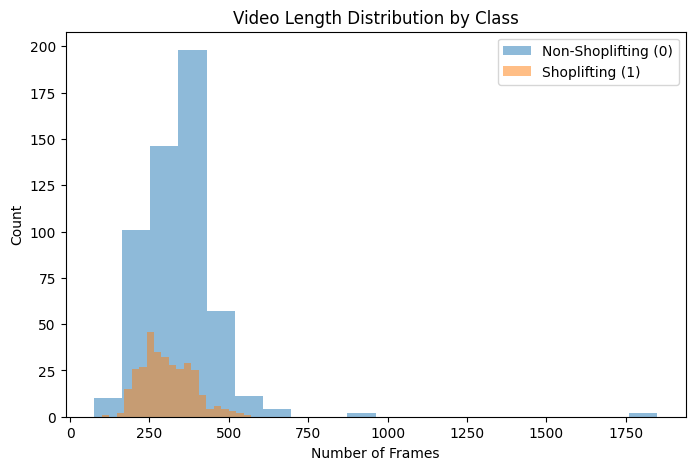

In [13]:
def visualize_video_lengths(videos, labels):
    lengths = []
    for v in videos:
        cap = cv2.VideoCapture(v)
        lengths.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
        cap.release()
    lengths_0 = [lengths[i] for i in range(len(labels)) if labels[i] == 0]
    lengths_1 = [lengths[i] for i in range(len(labels)) if labels[i] == 1]
    plt.figure(figsize=(8, 5))
    plt.hist(lengths_0, bins=20, alpha=0.5, label='Non-Shoplifting (0)')
    plt.hist(lengths_1, bins=20, alpha=0.5, label='Shoplifting (1)')
    plt.title('Video Length Distribution by Class')
    plt.xlabel('Number of Frames')
    plt.ylabel('Count')
    plt.legend()
    plt.show()


visualize_video_lengths(videos, labels)

Plots the length (in frames or seconds) of videos by class to check for imbalances in duration

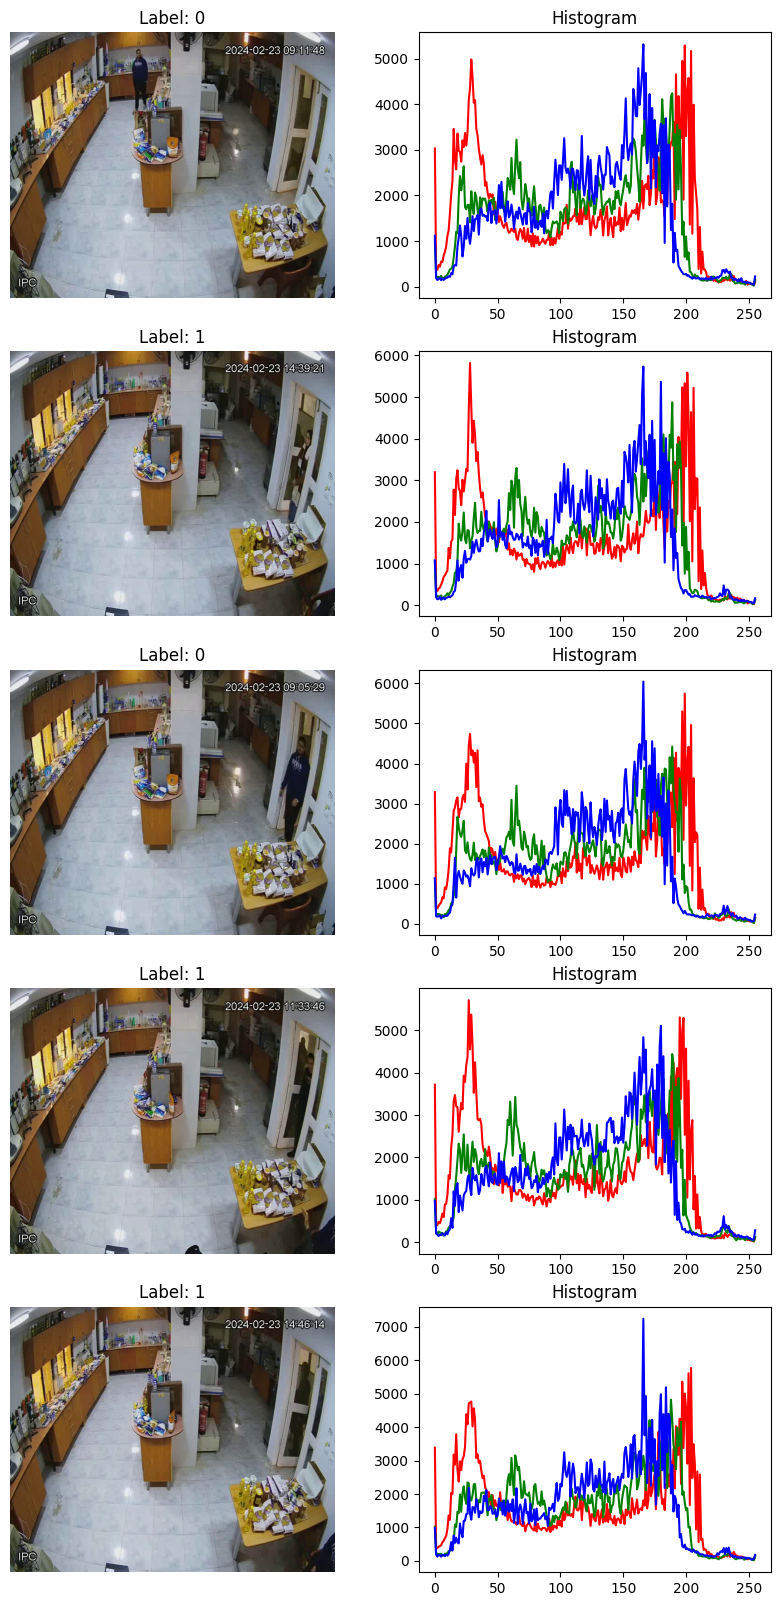

In [14]:
# Visualization: Sample frames and histograms
def visualize_data(videos, labels, num_samples=5):
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 20))
    for i in range(num_samples):
        video_path = random.choice(videos)
        cap = cv2.VideoCapture(video_path)
        ret, frame = cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            axs[i, 0].imshow(frame_rgb)
            axs[i, 0].set_title(f"Label: {labels[videos.index(video_path)]}")
            axs[i, 0].axis('off')
            hist_r = cv2.calcHist([frame], [0], None, [256], [0, 256])
            hist_g = cv2.calcHist([frame], [1], None, [256], [0, 256])
            hist_b = cv2.calcHist([frame], [2], None, [256], [0, 256])
            axs[i, 1].plot(hist_r, color='r')
            axs[i, 1].plot(hist_g, color='g')
            axs[i, 1].plot(hist_b, color='b')
            axs[i, 1].set_title("Histogram")
        cap.release()
    plt.show()

visualize_data(videos, labels)

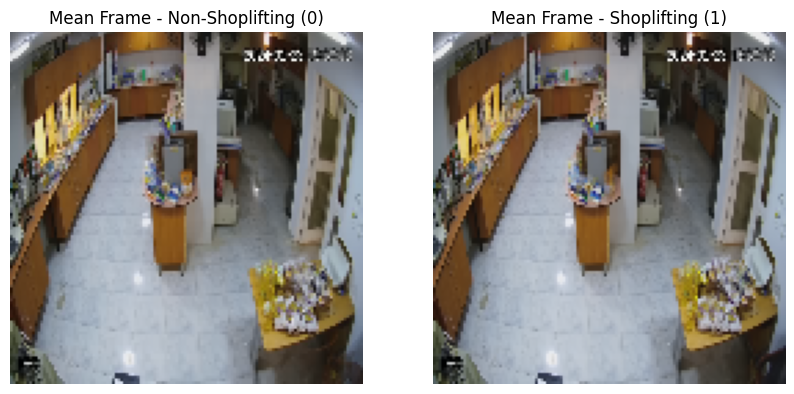

In [15]:
def visualize_mean_frame(videos, labels):
    mean_0 = np.zeros((128, 128, 3))
    mean_1 = np.zeros((128, 128, 3))
    count_0 = count_1 = 0
    for v, label in zip(videos, labels):
        cap = cv2.VideoCapture(v)
        ret, frame = cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_rgb = cv2.resize(frame_rgb, (128, 128)) / 255.0
            if label == 0:
                mean_0 += frame_rgb
                count_0 += 1
            else:
                mean_1 += frame_rgb
                count_1 += 1
        cap.release()
    mean_0 /= count_0 if count_0 > 0 else 1
    mean_1 /= count_1 if count_1 > 0 else 1
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(mean_0)
    axs[0].set_title('Mean Frame - Non-Shoplifting (0)')
    axs[0].axis('off')
    axs[1].imshow(mean_1)
    axs[1].set_title('Mean Frame - Shoplifting (1)')
    axs[1].axis('off')
    plt.show()


visualize_mean_frame(videos, labels)

Computes and displays the average frame across all videos in each class to see overall visual patterns (e.g., common colors or layouts in shoplifting scenes).

## Data Augmentation

In [16]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),  # Reduced from 30 to avoid distortion
    transforms.RandomResizedCrop(96, scale=(0.8, 1.0)),  # Match new frame size
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),  # Reduced intensity
    transforms.ToTensor(),
])


In [17]:
def augment_video(video):
    # video shape: (C, T, H, W) -> need to iterate over T (frames)
    augmented_frames = []
    video = video.permute(1, 0, 2, 3)  # Convert to (T, C, H, W) for frame-wise processing
    for frame in video:  # Each frame has shape (C, H, W)
        if frame.shape[0] != 3:  # Ensure the frame has 3 channels
            raise ValueError(f"Expected frame with 3 channels, got {frame.shape[0]} channels.")
        frame = frame.permute(1, 2, 0)  # Convert to (H, W, C) for ToPILImage
        frame = frame.cpu().numpy()  # Convert to numpy array for ToPILImage
        augmented_frame = transform(frame)
        augmented_frames.append(augmented_frame)
    video_tensor = torch.stack(augmented_frames)  # Shape: (T, C, H, W)
    video_tensor = video_tensor.permute(1, 0, 2, 3)  # Convert back to (C, T, H, W)
    return video_tensor

## Models and Training

In [18]:
class VideoDataset(Dataset):
    def __init__(self, X, y, transform=None):
        # X shape: (N, T, H, W, C) -> transpose to (N, C, T, H, W)
        self.X = np.transpose(X, (0, 4, 1, 2, 3)).astype(np.float32)
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        video = torch.tensor(self.X[idx], dtype=torch.float32)
        if self.transform:
            video = augment_video(video)
        label = torch.tensor(self.y[idx], dtype=torch.float32)  # Remove .unsqueeze(0)
        return video, label

In [19]:
# CRITICAL: Split data BEFORE any oversampling to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train set class distribution:", Counter(y_train))
print("Test set class distribution:", Counter(y_test))

# Now oversample only the training set
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_indices = np.arange(len(X_train)).reshape(-1, 1)
X_train_indices_resampled, y_train_resampled = ros.fit_resample(X_train_indices, y_train)
X_train = X_train[X_train_indices_resampled.flatten()]
y_train = y_train_resampled

print("After oversampling train set:", Counter(y_train))
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

train_dataset = VideoDataset(X_train, y_train, transform=transform)
val_dataset = VideoDataset(X_test, y_test, transform=None)


Train set class distribution: Counter({np.int64(0): 425, np.int64(1): 259})
Test set class distribution: Counter({np.int64(0): 106, np.int64(1): 65})
After oversampling train set: Counter({np.int64(1): 425, np.int64(0): 425})
X_train shape: (850, 8, 96, 96, 3), X_test shape: (171, 8, 96, 96, 3)


In [20]:
# Create DataLoader with smaller batch size for memory efficiency
batch_size = 2  # Very small batch size to prevent memory issues
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False) 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")


Training batches: 425, Validation batches: 86


In [21]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.weight = weight
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)  # Convert logits to probabilities
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        if self.weight is not None:
            weight = self.weight[targets.long()]  # Apply weight based on target class
        else:
            weight = torch.ones_like(targets)
        intersection = (inputs * targets * weight).sum()
        # FIXED: Added parentheses to ensure correct division
        dice = (2. * intersection + self.smooth) / ((inputs * weight).sum() + (targets * weight).sum() + self.smooth)
        return 1 - dice


In [22]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
# Clear GPU cache before training
import gc
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    print(f"GPU Memory allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    print(f"GPU Memory reserved: {torch.cuda.memory_reserved()/1024**3:.2f} GB")


GPU Memory allocated: 0.00 GB
GPU Memory reserved: 0.00 GB


In [24]:
def train_model(model, train_loader, val_loader, epochs=50, device=device):
    # Collect all labels to compute class weights
    all_labels = []
    for _, labels in train_loader:
        all_labels.append(labels.cpu().numpy().flatten())  # Flatten to 1D
    all_labels = np.concatenate(all_labels).astype(int)  # Ensure integer type

    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased LR, added weight decay
    class_counts = np.bincount(all_labels)
    num_samples = len(all_labels)
    class_weights = torch.tensor([num_samples / class_counts[0], num_samples / class_counts[1]], dtype=torch.float32).to(device)
    bce_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
    dice_loss_fn = DiceLoss(weight=class_weights)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    best_val_loss = float('inf')

    # Initialize GradScaler for mixed precision training
    scaler = GradScaler()

    for epoch in range(epochs):
        model.train()
        train_losses = []
        all_train_preds = []
        all_train_labels = []
        
        for videos, labels in train_loader:
            videos, labels = videos.to(device), labels.to(device)
            optimizer.zero_grad()
            # Use autocast for mixed precision
            with autocast():
                outputs = model(videos)
                bce_loss = bce_loss_fn(outputs, labels)
                dice_loss = dice_loss_fn(outputs, labels)
                loss = bce_loss + dice_loss
            # Scale the loss and backpropagate
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_losses.append(loss.item())
            all_train_preds.extend((torch.sigmoid(outputs) > 0.5).cpu().float().numpy())
            all_train_labels.extend(labels.cpu().numpy())
            
        avg_train_loss = np.mean(train_losses)
        train_acc = accuracy_score(all_train_labels, all_train_preds)
        train_f1 = f1_score(all_train_labels, all_train_preds, zero_division=1)
        train_recall = recall_score(all_train_labels, all_train_preds, zero_division=1)
        train_precision = precision_score(all_train_labels, all_train_preds, zero_division=1)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, F1: {train_f1:.4f}, Recall: {train_recall:.4f}, Precision: {train_precision:.4f}")

        model.eval()
        val_losses = []
        all_val_preds = []
        all_val_labels = []
        with torch.no_grad():
            for videos, labels in val_loader:
                videos, labels = videos.to(device), labels.to(device)
                outputs = model(videos)
                bce_loss = bce_loss_fn(outputs, labels)
                dice_loss = dice_loss_fn(outputs, labels)
                loss = bce_loss + dice_loss
                val_losses.append(loss.item())
                all_val_preds.extend((torch.sigmoid(outputs) > 0.5).cpu().float().numpy())
                all_val_labels.extend(labels.cpu().numpy())
                
        avg_val_loss = np.mean(val_losses)
        scheduler.step(avg_val_loss)
        
        val_acc = accuracy_score(all_val_labels, all_val_preds)
        val_f1 = f1_score(all_val_labels, all_val_preds, zero_division=1)
        val_recall = recall_score(all_val_labels, all_val_preds, zero_division=1)
        val_precision = precision_score(all_val_labels, all_val_preds, zero_division=1)
        
        # Print learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{epochs}], Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, F1: {val_f1:.4f}, Recall: {val_recall:.4f}, Precision: {val_precision:.4f}, LR: {current_lr:.6f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("✓ Best model saved!")
        
        print("-" * 80)


In [25]:
class PretrainedResNet3D(nn.Module):
    def __init__(self):
        super(PretrainedResNet3D, self).__init__()
        self.model = r3d_18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)  # Binary classification

    def forward(self, x):
        return self.model(x).squeeze(1)  # Squeeze to (N,)


In [26]:
class PretrainedMC3_18(nn.Module):
    def __init__(self):
        super(PretrainedMC3_18, self).__init__()
        self.model = mc3_18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)  # Binary classification

    def forward(self, x):
        return self.model(x).squeeze(1)  # Squeeze to (N,)

In [27]:
class PretrainedR2Plus1D_18(nn.Module):
    def __init__(self):
        super(PretrainedR2Plus1D_18, self).__init__()
        self.model = r2plus1d_18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)  # Binary classification

    def forward(self, x):
        return self.model(x).squeeze(1)  # Squeeze to (N,)

In [28]:
# Models
model1 = PretrainedResNet3D().to(device)
model2 = PretrainedMC3_18().to(device)
model3 = PretrainedR2Plus1D_18().to(device)

/mnt/d/Cellula_Internship/Task3/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/d/Cellula_Internship/Task3/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/mnt/d/Cellula_Internship/Task3/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MC3_18_Weights.KINETICS400_V1`. You ca

In [29]:
y = np.array(labels, dtype=np.float32)

In [30]:
print("Training Model 1 (ResNet3D):")
train_model(model1, train_loader, val_loader, device=device)

Training Model 1 (ResNet3D):


/tmp/ipykernel_796/3963339282.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50], Train Loss: 1.4184, Train Acc: 0.6094, F1: 0.6745, Recall: 0.8094, Precision: 0.5782
Epoch [1/50], Val Loss: 1.5171, Val Acc: 0.6725, F1: 0.2632, Recall: 0.1538, Precision: 0.9091, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [2/50], Train Loss: 1.0460, Train Acc: 0.7518, F1: 0.7831, Recall: 0.8965, Precision: 0.6953
Epoch [2/50], Val Loss: 1.0937, Val Acc: 0.7427, F1: 0.7471, Recall: 1.0000, Precision: 0.5963, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [3/50], Train Loss: 0.8672, Train Acc: 0.8447, F1: 0.8581, Recall: 0.9388, Precision: 0.7901
Epoch [3/50], Val Loss: 1.2924, Val Acc: 0.4737, F1: 0.5909, Recall: 1.0000, Precision: 0.4194, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [4/50], Train Loss: 0.6477, Train Acc: 0.8988, F1: 0.9040, Recall: 0.9529, Precision: 0.8599
Epoch [4/50], Val Loss: 0.9231, Val Acc: 0.8655, F1: 0.8497, Recall: 1.0000, Precision: 0.7386, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [5/50], Train Loss: 0.6071, Train Acc: 0.9153, F1: 0.9193, Recall: 0.9647, Precision: 0.8779
Epoch [5/50], Val Loss: 0.9060, Val Acc: 0.7953, F1: 0.7879, Recall: 1.0000, Precision: 0.6500, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [6/50], Train Loss: 0.5388, Train Acc: 0.9353, F1: 0.9380, Recall: 0.9788, Precision: 0.9004
Epoch [6/50], Val Loss: 0.5913, Val Acc: 0.9825, F1: 0.9774, Recall: 1.0000, Precision: 0.9559, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [7/50], Train Loss: 0.5290, Train Acc: 0.9388, F1: 0.9408, Recall: 0.9718, Precision: 0.9117
Epoch [7/50], Val Loss: 1.0986, Val Acc: 0.4971, F1: 0.6019, Recall: 1.0000, Precision: 0.4305, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [8/50], Train Loss: 0.4245, Train Acc: 0.9671, F1: 0.9677, Recall: 0.9882, Precision: 0.9481
Epoch [8/50], Val Loss: 0.9267, Val Acc: 0.9064, F1: 0.8596, Recall: 0.7538, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [9/50], Train Loss: 0.4465, Train Acc: 0.9588, F1: 0.9596, Recall: 0.9788, Precision: 0.9412
Epoch [9/50], Val Loss: 0.4748, Val Acc: 0.9591, F1: 0.9489, Recall: 1.0000, Precision: 0.9028, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [10/50], Train Loss: 0.4346, Train Acc: 0.9635, F1: 0.9641, Recall: 0.9788, Precision: 0.9498
Epoch [10/50], Val Loss: 0.5194, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [11/50], Train Loss: 0.3707, Train Acc: 0.9800, F1: 0.9802, Recall: 0.9906, Precision: 0.9700
Epoch [11/50], Val Loss: 0.5391, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [12/50], Train Loss: 0.3856, Train Acc: 0.9671, F1: 0.9677, Recall: 0.9859, Precision: 0.9501
Epoch [12/50], Val Loss: 0.4221, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [13/50], Train Loss: 0.3444, Train Acc: 0.9788, F1: 0.9790, Recall: 0.9882, Precision: 0.9700
Epoch [13/50], Val Loss: 0.5531, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [14/50], Train Loss: 0.3835, Train Acc: 0.9682, F1: 0.9688, Recall: 0.9859, Precision: 0.9523
Epoch [14/50], Val Loss: 0.7642, Val Acc: 0.9532, F1: 0.9344, Recall: 0.8769, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [15/50], Train Loss: 0.3522, Train Acc: 0.9718, F1: 0.9722, Recall: 0.9882, Precision: 0.9567
Epoch [15/50], Val Loss: 0.4743, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [16/50], Train Loss: 0.3495, Train Acc: 0.9835, F1: 0.9837, Recall: 0.9929, Precision: 0.9746
Epoch [16/50], Val Loss: 0.4610, Val Acc: 0.9825, F1: 0.9774, Recall: 1.0000, Precision: 0.9559, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [17/50], Train Loss: 0.3473, Train Acc: 0.9765, F1: 0.9767, Recall: 0.9859, Precision: 0.9677
Epoch [17/50], Val Loss: 0.4230, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [18/50], Train Loss: 0.3087, Train Acc: 0.9906, F1: 0.9907, Recall: 0.9976, Precision: 0.9838
Epoch [18/50], Val Loss: 0.4012, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [19/50], Train Loss: 0.3120, Train Acc: 0.9894, F1: 0.9895, Recall: 0.9953, Precision: 0.9837
Epoch [19/50], Val Loss: 0.4265, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [20/50], Train Loss: 0.3132, Train Acc: 0.9847, F1: 0.9848, Recall: 0.9906, Precision: 0.9791
Epoch [20/50], Val Loss: 0.4973, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [21/50], Train Loss: 0.3171, Train Acc: 0.9847, F1: 0.9848, Recall: 0.9882, Precision: 0.9813
Epoch [21/50], Val Loss: 0.4554, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [22/50], Train Loss: 0.3145, Train Acc: 0.9882, F1: 0.9882, Recall: 0.9882, Precision: 0.9882
Epoch [22/50], Val Loss: 0.5259, Val Acc: 0.9942, F1: 0.9924, Recall: 1.0000, Precision: 0.9848, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [23/50], Train Loss: 0.3231, Train Acc: 0.9800, F1: 0.9802, Recall: 0.9906, Precision: 0.9700
Epoch [23/50], Val Loss: 0.3910, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [24/50], Train Loss: 0.3204, Train Acc: 0.9847, F1: 0.9848, Recall: 0.9906, Precision: 0.9791
Epoch [24/50], Val Loss: 0.4990, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [25/50], Train Loss: 0.2427, Train Acc: 0.9988, F1: 0.9988, Recall: 1.0000, Precision: 0.9977
Epoch [25/50], Val Loss: 0.4010, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [26/50], Train Loss: 0.2787, Train Acc: 0.9941, F1: 0.9941, Recall: 0.9953, Precision: 0.9930
Epoch [26/50], Val Loss: 0.3966, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [27/50], Train Loss: 0.2859, Train Acc: 0.9941, F1: 0.9941, Recall: 0.9929, Precision: 0.9953
Epoch [27/50], Val Loss: 0.3980, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [28/50], Train Loss: 0.3777, Train Acc: 0.9800, F1: 0.9802, Recall: 0.9906, Precision: 0.9700
Epoch [28/50], Val Loss: 0.4015, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [29/50], Train Loss: 0.3233, Train Acc: 0.9812, F1: 0.9814, Recall: 0.9906, Precision: 0.9723
Epoch [29/50], Val Loss: 0.3893, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [30/50], Train Loss: 0.2710, Train Acc: 0.9953, F1: 0.9953, Recall: 0.9976, Precision: 0.9930
Epoch [30/50], Val Loss: 0.4066, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [31/50], Train Loss: 0.2719, Train Acc: 0.9941, F1: 0.9941, Recall: 0.9976, Precision: 0.9907
Epoch [31/50], Val Loss: 0.3869, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [32/50], Train Loss: 0.2910, Train Acc: 0.9882, F1: 0.9882, Recall: 0.9882, Precision: 0.9882
Epoch [32/50], Val Loss: 0.4422, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [33/50], Train Loss: 0.3094, Train Acc: 0.9894, F1: 0.9895, Recall: 0.9953, Precision: 0.9837
Epoch [33/50], Val Loss: 0.4143, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [34/50], Train Loss: 0.2879, Train Acc: 0.9953, F1: 0.9953, Recall: 1.0000, Precision: 0.9907
Epoch [34/50], Val Loss: 0.3868, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [35/50], Train Loss: 0.3211, Train Acc: 0.9871, F1: 0.9872, Recall: 0.9953, Precision: 0.9792
Epoch [35/50], Val Loss: 0.4206, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [36/50], Train Loss: 0.2911, Train Acc: 0.9965, F1: 0.9965, Recall: 0.9976, Precision: 0.9953
Epoch [36/50], Val Loss: 0.4616, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [37/50], Train Loss: 0.2773, Train Acc: 0.9929, F1: 0.9930, Recall: 0.9976, Precision: 0.9883
Epoch [37/50], Val Loss: 0.4738, Val Acc: 0.9883, F1: 0.9848, Recall: 1.0000, Precision: 0.9701, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [38/50], Train Loss: 0.2997, Train Acc: 0.9871, F1: 0.9872, Recall: 0.9953, Precision: 0.9792
Epoch [38/50], Val Loss: 0.7828, Val Acc: 0.9357, F1: 0.9076, Recall: 0.8308, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [39/50], Train Loss: 0.2751, Train Acc: 0.9953, F1: 0.9953, Recall: 0.9953, Precision: 0.9953
Epoch [39/50], Val Loss: 0.4539, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [40/50], Train Loss: 0.2959, Train Acc: 0.9918, F1: 0.9918, Recall: 0.9929, Precision: 0.9906
Epoch [40/50], Val Loss: 0.4609, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [41/50], Train Loss: 0.2585, Train Acc: 0.9953, F1: 0.9953, Recall: 0.9976, Precision: 0.9930
Epoch [41/50], Val Loss: 0.4327, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [42/50], Train Loss: 0.2571, Train Acc: 0.9965, F1: 0.9965, Recall: 0.9953, Precision: 0.9976
Epoch [42/50], Val Loss: 0.3987, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [43/50], Train Loss: 0.2951, Train Acc: 0.9965, F1: 0.9965, Recall: 0.9976, Precision: 0.9953
Epoch [43/50], Val Loss: 0.4047, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [44/50], Train Loss: 0.2372, Train Acc: 0.9988, F1: 0.9988, Recall: 1.0000, Precision: 0.9977
Epoch [44/50], Val Loss: 0.3930, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [45/50], Train Loss: 0.2634, Train Acc: 0.9988, F1: 0.9988, Recall: 1.0000, Precision: 0.9977
Epoch [45/50], Val Loss: 0.3901, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [46/50], Train Loss: 0.2688, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [46/50], Val Loss: 0.3830, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [47/50], Train Loss: 0.2590, Train Acc: 0.9976, F1: 0.9976, Recall: 0.9976, Precision: 0.9976
Epoch [47/50], Val Loss: 0.3905, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [48/50], Train Loss: 0.2711, Train Acc: 0.9988, F1: 0.9988, Recall: 1.0000, Precision: 0.9977
Epoch [48/50], Val Loss: 0.3907, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [49/50], Train Loss: 0.2490, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [49/50], Val Loss: 0.3824, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [50/50], Train Loss: 0.2790, Train Acc: 0.9988, F1: 0.9988, Recall: 1.0000, Precision: 0.9977
Epoch [50/50], Val Loss: 0.3873, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


In [31]:
print("Training Model 2 (mc3_18):")
train_model(model2, train_loader, val_loader, device=device)

Training Model 2 (mc3_18):


/tmp/ipykernel_796/3963339282.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50], Train Loss: 1.1757, Train Acc: 0.7094, F1: 0.7446, Recall: 0.8471, Precision: 0.6642
Epoch [1/50], Val Loss: 0.6943, Val Acc: 0.9532, F1: 0.9403, Recall: 0.9692, Precision: 0.9130, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [2/50], Train Loss: 0.9237, Train Acc: 0.7824, F1: 0.8075, Recall: 0.9129, Precision: 0.7239
Epoch [2/50], Val Loss: 0.9128, Val Acc: 0.7836, F1: 0.7784, Recall: 1.0000, Precision: 0.6373, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [3/50], Train Loss: 0.7084, Train Acc: 0.8671, F1: 0.8786, Recall: 0.9624, Precision: 0.8083
Epoch [3/50], Val Loss: 0.5038, Val Acc: 0.9708, F1: 0.9624, Recall: 0.9846, Precision: 0.9412, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [4/50], Train Loss: 0.5510, Train Acc: 0.9200, F1: 0.9239, Recall: 0.9718, Precision: 0.8806
Epoch [4/50], Val Loss: 0.5072, Val Acc: 0.9883, F1: 0.9846, Recall: 0.9846, Precision: 0.9846, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [5/50], Train Loss: 0.4601, Train Acc: 0.9635, F1: 0.9645, Recall: 0.9906, Precision: 0.9397
Epoch [5/50], Val Loss: 0.5446, Val Acc: 0.9942, F1: 0.9922, Recall: 0.9846, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [6/50], Train Loss: 0.3538, Train Acc: 0.9812, F1: 0.9815, Recall: 0.9976, Precision: 0.9658
Epoch [6/50], Val Loss: 0.4062, Val Acc: 0.9942, F1: 0.9924, Recall: 1.0000, Precision: 0.9848, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [7/50], Train Loss: 0.3186, Train Acc: 0.9788, F1: 0.9791, Recall: 0.9929, Precision: 0.9657
Epoch [7/50], Val Loss: 0.4247, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [8/50], Train Loss: 0.3642, Train Acc: 0.9800, F1: 0.9803, Recall: 0.9929, Precision: 0.9679
Epoch [8/50], Val Loss: 1.1504, Val Acc: 0.8363, F1: 0.7255, Recall: 0.5692, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [9/50], Train Loss: 0.2920, Train Acc: 0.9906, F1: 0.9907, Recall: 0.9976, Precision: 0.9838
Epoch [9/50], Val Loss: 0.9167, Val Acc: 0.8947, F1: 0.8393, Recall: 0.7231, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [10/50], Train Loss: 0.3087, Train Acc: 0.9859, F1: 0.9860, Recall: 0.9953, Precision: 0.9769
Epoch [10/50], Val Loss: 0.4714, Val Acc: 0.9649, F1: 0.9559, Recall: 1.0000, Precision: 0.9155, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [11/50], Train Loss: 0.2959, Train Acc: 0.9941, F1: 0.9941, Recall: 0.9976, Precision: 0.9907
Epoch [11/50], Val Loss: 0.3884, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [12/50], Train Loss: 0.3141, Train Acc: 0.9800, F1: 0.9803, Recall: 0.9929, Precision: 0.9679
Epoch [12/50], Val Loss: 0.4025, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [13/50], Train Loss: 0.2702, Train Acc: 0.9988, F1: 0.9988, Recall: 1.0000, Precision: 0.9977
Epoch [13/50], Val Loss: 0.3783, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [14/50], Train Loss: 0.2723, Train Acc: 0.9965, F1: 0.9965, Recall: 0.9976, Precision: 0.9953
Epoch [14/50], Val Loss: 0.3778, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [15/50], Train Loss: 0.2745, Train Acc: 0.9918, F1: 0.9918, Recall: 0.9929, Precision: 0.9906
Epoch [15/50], Val Loss: 0.3925, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [16/50], Train Loss: 0.2742, Train Acc: 0.9965, F1: 0.9965, Recall: 0.9976, Precision: 0.9953
Epoch [16/50], Val Loss: 0.3938, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [17/50], Train Loss: 0.2649, Train Acc: 0.9988, F1: 0.9988, Recall: 1.0000, Precision: 0.9977
Epoch [17/50], Val Loss: 0.3822, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [18/50], Train Loss: 0.2411, Train Acc: 0.9976, F1: 0.9977, Recall: 1.0000, Precision: 0.9953
Epoch [18/50], Val Loss: 0.3927, Val Acc: 0.9942, F1: 0.9922, Recall: 0.9846, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [19/50], Train Loss: 0.3193, Train Acc: 0.9882, F1: 0.9883, Recall: 0.9929, Precision: 0.9837
Epoch [19/50], Val Loss: 0.6656, Val Acc: 0.9357, F1: 0.9220, Recall: 1.0000, Precision: 0.8553, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [20/50], Train Loss: 0.2694, Train Acc: 0.9871, F1: 0.9871, Recall: 0.9906, Precision: 0.9836
Epoch [20/50], Val Loss: 0.3911, Val Acc: 0.9883, F1: 0.9848, Recall: 1.0000, Precision: 0.9701, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [21/50], Train Loss: 0.3081, Train Acc: 0.9894, F1: 0.9895, Recall: 0.9953, Precision: 0.9837
Epoch [21/50], Val Loss: 0.3879, Val Acc: 0.9942, F1: 0.9924, Recall: 1.0000, Precision: 0.9848, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [22/50], Train Loss: 0.2626, Train Acc: 0.9953, F1: 0.9953, Recall: 0.9976, Precision: 0.9930
Epoch [22/50], Val Loss: 0.3803, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [23/50], Train Loss: 0.2805, Train Acc: 0.9941, F1: 0.9941, Recall: 0.9976, Precision: 0.9907
Epoch [23/50], Val Loss: 0.3732, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [24/50], Train Loss: 0.2674, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [24/50], Val Loss: 0.3746, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [25/50], Train Loss: 0.2655, Train Acc: 0.9988, F1: 0.9988, Recall: 1.0000, Precision: 0.9977
Epoch [25/50], Val Loss: 0.3726, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [26/50], Train Loss: 0.2691, Train Acc: 0.9965, F1: 0.9965, Recall: 0.9976, Precision: 0.9953
Epoch [26/50], Val Loss: 0.3810, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [27/50], Train Loss: 0.2750, Train Acc: 0.9988, F1: 0.9988, Recall: 1.0000, Precision: 0.9977
Epoch [27/50], Val Loss: 0.3716, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [28/50], Train Loss: 0.2444, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [28/50], Val Loss: 0.3716, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [29/50], Train Loss: 0.2618, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [29/50], Val Loss: 0.3781, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [30/50], Train Loss: 0.2553, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [30/50], Val Loss: 0.3808, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [31/50], Train Loss: 0.2408, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [31/50], Val Loss: 0.3723, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [32/50], Train Loss: 0.2651, Train Acc: 0.9976, F1: 0.9977, Recall: 1.0000, Precision: 0.9953
Epoch [32/50], Val Loss: 0.3727, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [33/50], Train Loss: 0.2564, Train Acc: 0.9976, F1: 0.9976, Recall: 0.9976, Precision: 0.9976
Epoch [33/50], Val Loss: 0.3702, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [34/50], Train Loss: 0.2604, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [34/50], Val Loss: 0.3727, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [35/50], Train Loss: 0.2628, Train Acc: 0.9965, F1: 0.9965, Recall: 0.9976, Precision: 0.9953
Epoch [35/50], Val Loss: 0.4021, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [36/50], Train Loss: 0.2555, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [36/50], Val Loss: 0.3880, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [37/50], Train Loss: 0.2242, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [37/50], Val Loss: 0.4006, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [38/50], Train Loss: 0.2286, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [38/50], Val Loss: 0.3801, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [39/50], Train Loss: 0.2519, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [39/50], Val Loss: 0.3793, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000025
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [40/50], Train Loss: 0.2283, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [40/50], Val Loss: 0.3770, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000025
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [41/50], Train Loss: 0.2731, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [41/50], Val Loss: 0.3797, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000025
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [42/50], Train Loss: 0.2446, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [42/50], Val Loss: 0.3752, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000025
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [43/50], Train Loss: 0.2608, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [43/50], Val Loss: 0.3730, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000025
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [44/50], Train Loss: 0.2319, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [44/50], Val Loss: 0.3710, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000025
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [45/50], Train Loss: 0.2638, Train Acc: 0.9965, F1: 0.9965, Recall: 0.9953, Precision: 0.9976
Epoch [45/50], Val Loss: 0.3664, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000025
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [46/50], Train Loss: 0.1364, Train Acc: 0.9965, F1: 0.9965, Recall: 0.9976, Precision: 0.9953
Epoch [46/50], Val Loss: 0.2558, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000025
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [47/50], Train Loss: 0.0474, Train Acc: 0.9988, F1: 0.9988, Recall: 0.9976, Precision: 1.0000
Epoch [47/50], Val Loss: 0.3882, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000025
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [48/50], Train Loss: 0.0350, Train Acc: 0.9988, F1: 0.9988, Recall: 0.9976, Precision: 1.0000
Epoch [48/50], Val Loss: 0.3623, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000025
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [49/50], Train Loss: 0.0079, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [49/50], Val Loss: 0.3382, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000025
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [50/50], Train Loss: 0.0039, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [50/50], Val Loss: 0.2225, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000025
✓ Best model saved!
--------------------------------------------------------------------------------


In [42]:
print("Training Model 3 (r2plus1d_18):")
train_model(model3, train_loader, val_loader, device=device)

Training Model 3 (r2plus1d_18):


/tmp/ipykernel_796/3963339282.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50], Train Loss: 1.3639, Train Acc: 0.6047, F1: 0.6693, Recall: 0.8000, Precision: 0.5753
Epoch [1/50], Val Loss: 1.5008, Val Acc: 0.7544, F1: 0.6038, Recall: 0.4923, Precision: 0.7805, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [2/50], Train Loss: 0.9126, Train Acc: 0.8059, F1: 0.8283, Recall: 0.9365, Precision: 0.7425
Epoch [2/50], Val Loss: 0.8141, Val Acc: 0.9591, F1: 0.9440, Recall: 0.9077, Precision: 0.9833, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [3/50], Train Loss: 0.6689, Train Acc: 0.8882, F1: 0.8962, Recall: 0.9647, Precision: 0.8367
Epoch [3/50], Val Loss: 0.8839, Val Acc: 0.9708, F1: 0.9600, Recall: 0.9231, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [4/50], Train Loss: 0.5771, Train Acc: 0.9247, F1: 0.9281, Recall: 0.9718, Precision: 0.8882
Epoch [4/50], Val Loss: 0.8028, Val Acc: 0.9942, F1: 0.9924, Recall: 1.0000, Precision: 0.9848, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [5/50], Train Loss: 0.4705, Train Acc: 0.9447, F1: 0.9465, Recall: 0.9788, Precision: 0.9163
Epoch [5/50], Val Loss: 0.7678, Val Acc: 0.9591, F1: 0.9489, Recall: 1.0000, Precision: 0.9028, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [6/50], Train Loss: 0.4433, Train Acc: 0.9518, F1: 0.9531, Recall: 0.9812, Precision: 0.9267
Epoch [6/50], Val Loss: 0.5705, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [7/50], Train Loss: 0.3880, Train Acc: 0.9718, F1: 0.9723, Recall: 0.9906, Precision: 0.9546
Epoch [7/50], Val Loss: 0.5024, Val Acc: 0.9591, F1: 0.9489, Recall: 1.0000, Precision: 0.9028, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [8/50], Train Loss: 0.3419, Train Acc: 0.9788, F1: 0.9792, Recall: 0.9953, Precision: 0.9636
Epoch [8/50], Val Loss: 0.6036, Val Acc: 0.9064, F1: 0.8904, Recall: 1.0000, Precision: 0.8025, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [9/50], Train Loss: 0.3882, Train Acc: 0.9694, F1: 0.9697, Recall: 0.9788, Precision: 0.9607
Epoch [9/50], Val Loss: 0.5884, Val Acc: 0.9591, F1: 0.9489, Recall: 1.0000, Precision: 0.9028, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [10/50], Train Loss: 0.3794, Train Acc: 0.9753, F1: 0.9755, Recall: 0.9835, Precision: 0.9676
Epoch [10/50], Val Loss: 0.5558, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [11/50], Train Loss: 0.2490, Train Acc: 0.9988, F1: 0.9988, Recall: 1.0000, Precision: 0.9977
Epoch [11/50], Val Loss: 0.4418, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [12/50], Train Loss: 0.2951, Train Acc: 0.9882, F1: 0.9883, Recall: 0.9953, Precision: 0.9814
Epoch [12/50], Val Loss: 0.6063, Val Acc: 0.9649, F1: 0.9516, Recall: 0.9077, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [13/50], Train Loss: 0.4261, Train Acc: 0.9565, F1: 0.9573, Recall: 0.9765, Precision: 0.9389
Epoch [13/50], Val Loss: 0.9406, Val Acc: 0.9181, F1: 0.8793, Recall: 0.7846, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [14/50], Train Loss: 0.3348, Train Acc: 0.9800, F1: 0.9803, Recall: 0.9976, Precision: 0.9636
Epoch [14/50], Val Loss: 1.3463, Val Acc: 0.8421, F1: 0.7379, Recall: 0.5846, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [15/50], Train Loss: 0.3049, Train Acc: 0.9871, F1: 0.9871, Recall: 0.9882, Precision: 0.9859
Epoch [15/50], Val Loss: 0.5732, Val Acc: 0.9474, F1: 0.9256, Recall: 0.8615, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [16/50], Train Loss: 0.2636, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [16/50], Val Loss: 0.4034, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [17/50], Train Loss: 0.3065, Train Acc: 0.9859, F1: 0.9860, Recall: 0.9929, Precision: 0.9791
Epoch [17/50], Val Loss: 0.4490, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [18/50], Train Loss: 0.3545, Train Acc: 0.9776, F1: 0.9779, Recall: 0.9882, Precision: 0.9677
Epoch [18/50], Val Loss: 0.4629, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [19/50], Train Loss: 0.2745, Train Acc: 0.9918, F1: 0.9918, Recall: 0.9953, Precision: 0.9883
Epoch [19/50], Val Loss: 0.5001, Val Acc: 0.9708, F1: 0.9600, Recall: 0.9231, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [20/50], Train Loss: 0.3825, Train Acc: 0.9671, F1: 0.9676, Recall: 0.9835, Precision: 0.9522
Epoch [20/50], Val Loss: 0.4665, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [21/50], Train Loss: 0.2808, Train Acc: 0.9953, F1: 0.9953, Recall: 1.0000, Precision: 0.9907
Epoch [21/50], Val Loss: 0.4063, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [22/50], Train Loss: 0.2500, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [22/50], Val Loss: 0.3812, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [23/50], Train Loss: 0.2704, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [23/50], Val Loss: 0.4420, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [24/50], Train Loss: 0.2413, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [24/50], Val Loss: 0.4129, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [25/50], Train Loss: 0.3351, Train Acc: 0.9871, F1: 0.9871, Recall: 0.9882, Precision: 0.9859
Epoch [25/50], Val Loss: 0.5118, Val Acc: 0.9708, F1: 0.9600, Recall: 0.9231, Precision: 1.0000, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [26/50], Train Loss: 0.3665, Train Acc: 0.9694, F1: 0.9698, Recall: 0.9812, Precision: 0.9586
Epoch [26/50], Val Loss: 0.9182, Val Acc: 0.7310, F1: 0.7386, Recall: 1.0000, Precision: 0.5856, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [27/50], Train Loss: 0.2826, Train Acc: 0.9953, F1: 0.9953, Recall: 1.0000, Precision: 0.9907
Epoch [27/50], Val Loss: 0.4578, Val Acc: 0.9942, F1: 0.9924, Recall: 1.0000, Precision: 0.9848, LR: 0.000100
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [28/50], Train Loss: 0.2532, Train Acc: 0.9988, F1: 0.9988, Recall: 0.9976, Precision: 1.0000
Epoch [28/50], Val Loss: 0.5224, Val Acc: 0.9591, F1: 0.9489, Recall: 1.0000, Precision: 0.9028, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [29/50], Train Loss: 0.2589, Train Acc: 0.9988, F1: 0.9988, Recall: 1.0000, Precision: 0.9977
Epoch [29/50], Val Loss: 0.4668, Val Acc: 0.9883, F1: 0.9848, Recall: 1.0000, Precision: 0.9701, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [30/50], Train Loss: 0.2786, Train Acc: 0.9988, F1: 0.9988, Recall: 1.0000, Precision: 0.9977
Epoch [30/50], Val Loss: 0.6860, Val Acc: 0.8889, F1: 0.8725, Recall: 1.0000, Precision: 0.7738, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [31/50], Train Loss: 0.2606, Train Acc: 0.9953, F1: 0.9953, Recall: 0.9976, Precision: 0.9930
Epoch [31/50], Val Loss: 0.4212, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [32/50], Train Loss: 0.2645, Train Acc: 0.9988, F1: 0.9988, Recall: 1.0000, Precision: 0.9977
Epoch [32/50], Val Loss: 0.4103, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [33/50], Train Loss: 0.2497, Train Acc: 0.9941, F1: 0.9941, Recall: 0.9976, Precision: 0.9907
Epoch [33/50], Val Loss: 0.4181, Val Acc: 0.9942, F1: 0.9922, Recall: 0.9846, Precision: 1.0000, LR: 0.000050
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [34/50], Train Loss: 0.2444, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [34/50], Val Loss: 0.3868, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000025
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [35/50], Train Loss: 0.2446, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [35/50], Val Loss: 0.4002, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000025
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [36/50], Train Loss: 0.2782, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [36/50], Val Loss: 0.4500, Val Acc: 0.9942, F1: 0.9924, Recall: 1.0000, Precision: 0.9848, LR: 0.000025
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [37/50], Train Loss: 0.2595, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [37/50], Val Loss: 0.4322, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000025
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [38/50], Train Loss: 0.2570, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [38/50], Val Loss: 0.3977, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000025
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [39/50], Train Loss: 0.2836, Train Acc: 0.9988, F1: 0.9988, Recall: 0.9976, Precision: 1.0000
Epoch [39/50], Val Loss: 0.3894, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000025
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [40/50], Train Loss: 0.2642, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [40/50], Val Loss: 0.3936, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000013
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [41/50], Train Loss: 0.2758, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [41/50], Val Loss: 0.3886, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000013
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [42/50], Train Loss: 0.2711, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [42/50], Val Loss: 0.3849, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000013
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [43/50], Train Loss: 0.2592, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [43/50], Val Loss: 0.3807, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000013
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [44/50], Train Loss: 0.2615, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [44/50], Val Loss: 0.3821, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000013
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [45/50], Train Loss: 0.2497, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [45/50], Val Loss: 0.3835, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000013
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [46/50], Train Loss: 0.2615, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [46/50], Val Loss: 0.3773, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000013
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [47/50], Train Loss: 0.2566, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [47/50], Val Loss: 0.3762, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000013
✓ Best model saved!
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [48/50], Train Loss: 0.2448, Train Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000
Epoch [48/50], Val Loss: 0.3786, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000013
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [49/50], Train Loss: 0.2762, Train Acc: 0.9988, F1: 0.9988, Recall: 1.0000, Precision: 0.9977
Epoch [49/50], Val Loss: 0.3867, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000013
--------------------------------------------------------------------------------


/tmp/ipykernel_796/3963339282.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [50/50], Train Loss: 0.2315, Train Acc: 0.9988, F1: 0.9988, Recall: 1.0000, Precision: 0.9977
Epoch [50/50], Val Loss: 0.3865, Val Acc: 1.0000, F1: 1.0000, Recall: 1.0000, Precision: 1.0000, LR: 0.000013
--------------------------------------------------------------------------------


## Evaluation

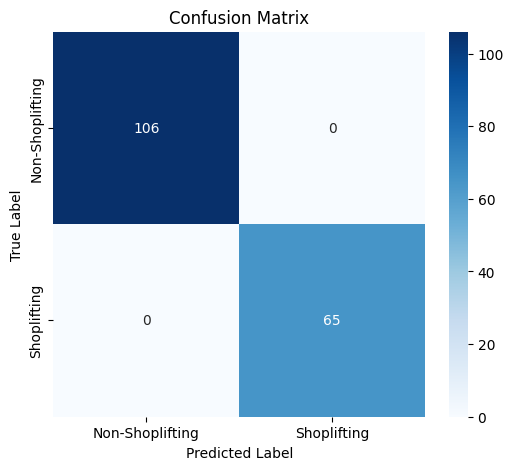

In [43]:
def plot_confusion_matrix(model, loader, device='cpu'):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_pred.extend((output > 0.5).cpu().numpy().astype(int))
            y_true.extend(target.cpu().numpy().astype(int))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Shoplifting', 'Shoplifting'], yticklabels=['Non-Shoplifting', 'Shoplifting'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


plot_confusion_matrix(model1, val_loader, device=device)

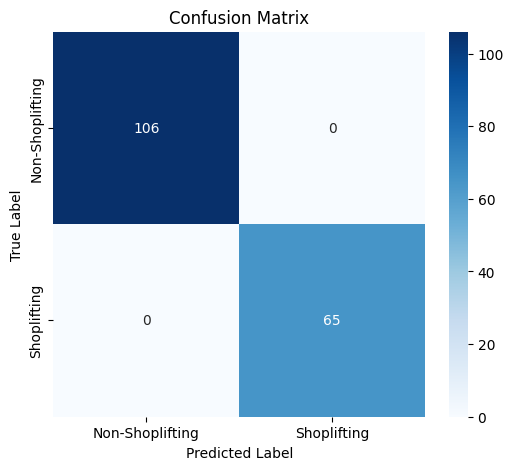

In [44]:
plot_confusion_matrix(model2, val_loader, device=device)

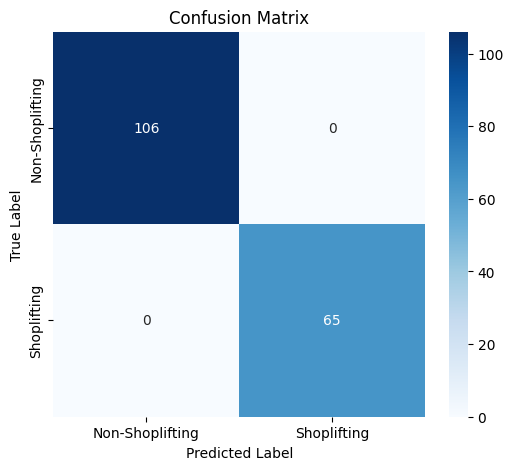

In [45]:
plot_confusion_matrix(model3, val_loader, device=device)

In [46]:
def print_classification_report(model, loader, device='cpu'):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_pred.extend((output > 0.5).cpu().numpy().astype(int))
            y_true.extend(target.cpu().numpy().astype(int))
    print(classification_report(y_true, y_pred, target_names=['Non-Shoplifting (0)', 'Shoplifting (1)']))

In [47]:
print("Model 1 Classification Report:")
print_classification_report(model1, val_loader, device=device)

Model 1 Classification Report:
                     precision    recall  f1-score   support

Non-Shoplifting (0)       1.00      1.00      1.00       106
    Shoplifting (1)       1.00      1.00      1.00        65

           accuracy                           1.00       171
          macro avg       1.00      1.00      1.00       171
       weighted avg       1.00      1.00      1.00       171



In [48]:
print("Model 2 Classification Report:")
print_classification_report(model2, val_loader, device=device)

Model 2 Classification Report:
                     precision    recall  f1-score   support

Non-Shoplifting (0)       1.00      1.00      1.00       106
    Shoplifting (1)       1.00      1.00      1.00        65

           accuracy                           1.00       171
          macro avg       1.00      1.00      1.00       171
       weighted avg       1.00      1.00      1.00       171



In [49]:
print("Model 3 Classification Report:")
print_classification_report(model3, val_loader, device=device)

Model 3 Classification Report:
                     precision    recall  f1-score   support

Non-Shoplifting (0)       1.00      1.00      1.00       106
    Shoplifting (1)       1.00      1.00      1.00        65

           accuracy                           1.00       171
          macro avg       1.00      1.00      1.00       171
       weighted avg       1.00      1.00      1.00       171



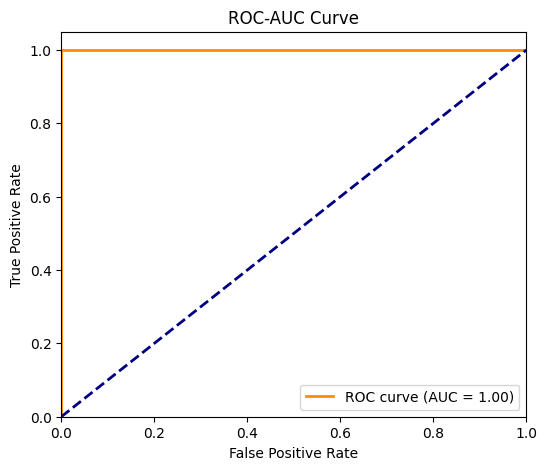

In [50]:
from sklearn.metrics import auc , roc_curve

def plot_roc_curve(model, loader, device='cpu'):
    model.eval()
    y_prob = []
    y_true = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_prob.extend(output.cpu().numpy())
            y_true.extend(target.cpu().numpy())
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()


plot_roc_curve(model1, val_loader, device=device)

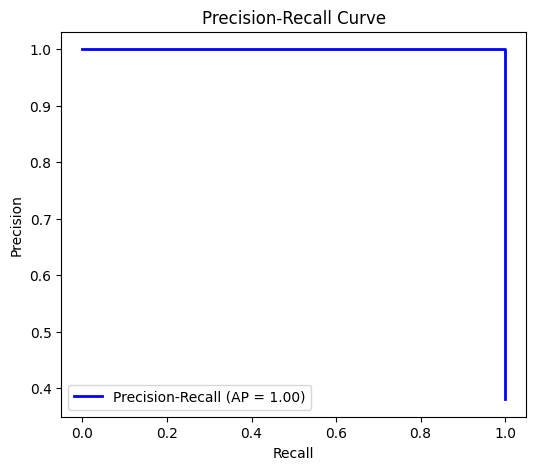

: 

In [ ]:
def plot_precision_recall(model, loader, device='cpu'):
    model.eval()
    y_prob = []
    y_true = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_prob.extend(output.cpu().numpy())
            y_true.extend(target.cpu().numpy())
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, lw=2, color='blue', label=f'Precision-Recall (AP = {ap:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()


plot_precision_recall(model1, val_loader, device=device)